## Demonstration of Single-Cell Benchmark Tasks
### Using cz-benchmarks to evaluate a model on multiple tasks

This notebook demonstrates how to leverage the `czbenchmarks` library to evaluate single-cell models on multiple benchmark tasks. `czbenchmarks` is a Python library designed to streamline benchmarking for single-cell analysis tasks, such as clustering, embedding, and cell type classification. 


For demonstration purposes, we use `scVI`and showing performance of the published model weights for each of the following tasks: 
* `Clustering`
* `Embedding`
* `Cell Type Classification`

### Step 1: Setup and Imports

This step sets up the environment and imports necessary libraries for benchmarking single-cell models. Ensure that the virtual environment is created and dependencies are installed before proceeding.

In [74]:
# # Create isolated virtual environment for scVI and czbenchmarks (run once)

# !python3 -m venv .venv_scvi

# # Install model required packages
# !.venv_scvi/bin/python -m pip install --upgrade pip
# !.venv_scvi/bin/python -m pip install ipykernel numpy pandas scvi-tools tabulate matplotlib seaborn

# # Register the new environment as a Jupyter kernel (if not already registered)
# !.venv_scvi/bin/python -m ipykernel install --user --name venv_scvi --display-name "Python (.venv_scvi)"

# print("Virtual environment '.venv_scvi' created, dependencies installed, and kernel registered.")

In [2]:
from czbenchmarks.datasets import load_dataset
from czbenchmarks.datasets.single_cell_labeled import SingleCellLabeledDataset
from czbenchmarks.tasks import (
    ClusteringTask,
    EmbeddingTask,
    MetadataLabelPredictionTask,
)
from czbenchmarks.tasks.clustering import ClusteringTaskInput
from czbenchmarks.tasks.embedding import EmbeddingTaskInput
from czbenchmarks.tasks.label_prediction import MetadataLabelPredictionTaskInput

# Model specific imports
import scvi  # other imports can be used as required by model
import functools

# --- Visualization Imports ---
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Notebook config imports
import warnings

warnings.simplefilter("ignore")
sns.set_theme(style="whitegrid")


# utility functions
def summarize_results(results, source):
    """Summarize results into a DataFrame for easy comparison."""
    return pd.DataFrame(
        {
            "Source": source,
            "Metric": [r.metric_type.name for r in results],
            "Value": [r.value for r in results],
        }
    )


def plot_umap(embedding, labels, title):
    import scanpy as sc

    adata_vis = sc.AnnData(embedding)
    adata_vis.obs["cell_type"] = labels.values.astype(str)
    sc.pp.neighbors(adata_vis, use_rep="X")
    sc.tl.umap(adata_vis)
    sc.pl.umap(adata_vis, color="cell_type", title=title, frameon=False, show=False)


def plot_comparison(data, title, ylabel, palette):
    plt.figure(figsize=(10, 5))
    sns.barplot(data=data, x="Metric", y="Value", hue="Source", palette=palette)
    plt.title(title, fontsize=14)
    plt.ylabel(ylabel, fontsize=10)
    plt.xlabel("Metric", fontsize=10)
    plt.xticks(rotation=0, ha="right")
    plt.legend(title="Source")
    plt.tight_layout()
    plt.show()

### Step 2: Load a Dataset

Load the pre-configured `tsv2_prostate` dataset. The library handles automatic download, caching, and loading as a `SingleCellLabeledDataset` for streamlined reuse.

**Loaded dataset provides:**
- `dataset.adata`: AnnData object with gene expression data.
- `dataset.labels`: pandas Series of cell type labels.

In [3]:
# The 'dataset' object is a validated AnnData wrapper, ensuring efficient downstream processing.
dataset: SingleCellLabeledDataset = load_dataset("tsv2_prostate")
dataset.adata
dataset.labels

INFO:czbenchmarks.file_utils:File already exists in cache: /Users/sgupta/.cz-benchmarks/datasets/homo_sapiens_10df7690-6d10-4029-a47e-0f071bb2df83_Prostate_v2_curated.h5ad
INFO:czbenchmarks.datasets.single_cell:Loading dataset from /Users/sgupta/.cz-benchmarks/datasets/homo_sapiens_10df7690-6d10-4029-a47e-0f071bb2df83_Prostate_v2_curated.h5ad in memory mode.


TSP25_Prostate_NA_10X_1_1_AAACCCAAGTGGTTAA                       endothelial cell
TSP25_Prostate_NA_10X_1_1_AAACCCACATGCACTA    luminal cell of prostate epithelium
TSP25_Prostate_NA_10X_1_1_AAACGAAGTTCTGACA                       endothelial cell
TSP25_Prostate_NA_10X_1_1_AAACGCTTCTACCCAC                            erythrocyte
TSP25_Prostate_NA_10X_1_1_AAAGAACCAGTTGTCA                     smooth muscle cell
                                                             ...                 
TSP25_Prostate_NA_10X_1_2_TTTATGCTCTTGGTCC                             fibroblast
TSP25_Prostate_NA_10X_1_2_TTTCACAAGATCGGTG      basal cell of prostate epithelium
TSP25_Prostate_NA_10X_1_2_TTTCACAGTGCCTTCT                             fibroblast
TSP25_Prostate_NA_10X_1_2_TTTCATGCAATAGTAG        CD8-positive, alpha-beta T cell
TSP25_Prostate_NA_10X_1_2_TTTCCTCAGGTGATCG                             fibroblast
Name: cell_type, Length: 2044, dtype: category
Categories (14, object): ['fibroblast', 'T cell', '

#### Optionally Transform Data

After loading the dataset, you may need to transform the data to meet the requirements of your model.

In [4]:
required_obs_keys = ["dataset_id", "assay", "suspension_type", "donor_id"]
adata = dataset.adata.copy()

batch_keys = required_obs_keys
adata.obs["batch"] = functools.reduce(
    lambda a, b: a + b, [adata.obs[c].astype(str) for c in batch_keys]
)

### Step 3: Model Inference
Obtain the model weights associated with the pre-trained scVI model to use as a reference. Generate cell embeddings for evaluation within the benchmarking framework.

---
> **Note:** Ensure the model weights directory exists and contains the required `model.pt` file. If the weights are missing, refer to `examples/scvi_model_dev_workflow.ipynb` for instructions on obtaining them.

In [6]:
# Ensure model weights directory exists and model.pt file is present. Check `examples/scvi_model_dev_workflow.ipynb` for details on how to get the model weights.
model_weights_dir = "czbenchmarks_scvi_model"
scvi.model.SCVI.prepare_query_anndata(adata, model_weights_dir)
scvi_model = scvi.model.SCVI.load_query_data(adata, model_weights_dir)
scvi_model.is_trained = True

# Now, generate the latent representation (the embedding)
model_output = scvi_model.get_latent_representation()
print(f"Generated scVI embedding with shape: {model_output.shape}")

INFO     File czbenchmarks_scvi_model/model.pt already downloaded                                                  
INFO     Found 44.05% reference vars in query data.                                                                
INFO     File czbenchmarks_scvi_model/model.pt already downloaded                                                  
Generated scVI embedding with shape: (2044, 50)


### Step 4.  Benchmark Tasks

Evaluate the scVI model and PCA baseline across clustering, embedding, and cell type classification tasks.

#### Clustering Task

Evaluate clustering performance using metrics such as Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI).

In [ ]:
clustering_task = ClusteringTask()
clustering_task_input = ClusteringTaskInput(
    input_labels=dataset.labels
)

# Run clustering task
clustering_results = clustering_task.run(
    cell_representation=model_output, task_input=clustering_task_input
)

# Compute baseline
expression_data = dataset.adata.X
clustering_baseline = clustering_task.compute_baseline(expression_data)
clustering_baseline_results = clustering_task.run(
    cell_representation=clustering_baseline, task_input=clustering_task_input
)

In [8]:
# Display Clustering Results
df_clustering_model = summarize_results(clustering_results, "scVI Model")
df_clustering_baseline = summarize_results(clustering_baseline_results, "PCA Baseline")
df_clustering_compare = pd.concat(
    [df_clustering_model, df_clustering_baseline], ignore_index=True
)
print("Clustering Results Comparison:")
display(df_clustering_compare.T)

Clustering Results Comparison:


,0,1,2,3
Source,scVI Model,scVI Model,PCA Baseline,PCA Baseline
Metric,ADJUSTED_RAND_INDEX,NORMALIZED_MUTUAL_INFO,ADJUSTED_RAND_INDEX,NORMALIZED_MUTUAL_INFO
Value,0.71937,0.86654,0.642149,0.833138


#### Embedding Task

Evaluate embedding quality using silhouette scores to measure separation of cell types in the latent space.

In [9]:
embedding_task = EmbeddingTask()
embedding_task_input = EmbeddingTaskInput(input_labels=dataset.labels)

# Run embedding task
embedding_results_model = embedding_task.run(model_output, embedding_task_input)

# Compute baseline
embedding_baseline = embedding_task.compute_baseline(expression_data)
embedding_results_baseline = embedding_task.run(
    embedding_baseline, embedding_task_input
)

INFO:2025-09-16 10:10:59,113:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


In [10]:
# Display Embedding Results
df_embedding_model = summarize_results(embedding_results_model, "scVI Model")
df_embedding_baseline = summarize_results(embedding_results_baseline, "PCA Baseline")
df_embedding_compare = pd.concat(
    [df_embedding_model, df_embedding_baseline], ignore_index=True
)

print("Embedding Results Comparison:")
display(df_embedding_compare)

Embedding Results Comparison:


,Source,Metric,Value
0,scVI Model,SILHOUETTE_SCORE,0.627913
1,PCA Baseline,SILHOUETTE_SCORE,0.650182


#### Cell Type Classification Task

Evaluate cell type classification performance using accuracy and F1 scores.

In [11]:
prediction_task = MetadataLabelPredictionTask()
prediction_task_input = MetadataLabelPredictionTaskInput(labels=dataset.labels)

# Run prediction task
prediction_results_model = prediction_task.run(model_output, prediction_task_input)

# Compute baseline
prediction_baseline = prediction_task.compute_baseline(expression_data)
prediction_results_baseline = prediction_task.run(
    prediction_baseline, prediction_task_input
)

INFO:czbenchmarks.tasks.label_prediction:Starting prediction task for labels
INFO:czbenchmarks.tasks.label_prediction:Initial data shape: (2044, 50), labels shape: (2044,)
INFO:czbenchmarks.tasks.utils:Label composition (cell_type):
INFO:czbenchmarks.tasks.utils:Total classes before filtering: 14
INFO:czbenchmarks.tasks.utils:Total classes after filtering (min_class_size=10): 13
INFO:czbenchmarks.tasks.label_prediction:After filtering: (2043, 50) samples remaining
INFO:czbenchmarks.tasks.label_prediction:Found 13 classes, using macro averaging for metrics
INFO:czbenchmarks.tasks.label_prediction:Using 5-fold cross validation with random_seed 42
INFO:czbenchmarks.tasks.label_prediction:Created classifiers: ['lr', 'knn', 'rf']
INFO:czbenchmarks.tasks.label_prediction:Running cross-validation for lr...
INFO:czbenchmarks.tasks.label_prediction:Running cross-validation for knn...
INFO:czbenchmarks.tasks.label_prediction:Running cross-validation for rf...
INFO:czbenchmarks.tasks.label_predic

In [12]:
# Display Prediction Results
df_prediction_model = summarize_results(prediction_results_model, "scVI Model")
df_prediction_baseline = summarize_results(prediction_results_baseline, "PCA Baseline")
df_prediction_compare = pd.concat(
    [df_prediction_model, df_prediction_baseline], ignore_index=True
)

print("Prediction Results Comparison:")
display(df_prediction_compare.T)

Prediction Results Comparison:


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
Source,scVI Model,scVI Model,scVI Model,scVI Model,scVI Model,scVI Model,scVI Model,scVI Model,scVI Model,scVI Model,...,PCA Baseline,PCA Baseline,PCA Baseline,PCA Baseline,PCA Baseline,PCA Baseline,PCA Baseline,PCA Baseline,PCA Baseline,PCA Baseline
Metric,MEAN_FOLD_ACCURACY,MEAN_FOLD_F1_SCORE,MEAN_FOLD_PRECISION,MEAN_FOLD_RECALL,MEAN_FOLD_AUROC,MEAN_FOLD_ACCURACY,MEAN_FOLD_F1_SCORE,MEAN_FOLD_PRECISION,MEAN_FOLD_RECALL,MEAN_FOLD_AUROC,...,MEAN_FOLD_ACCURACY,MEAN_FOLD_F1_SCORE,MEAN_FOLD_PRECISION,MEAN_FOLD_RECALL,MEAN_FOLD_AUROC,MEAN_FOLD_ACCURACY,MEAN_FOLD_F1_SCORE,MEAN_FOLD_PRECISION,MEAN_FOLD_RECALL,MEAN_FOLD_AUROC
Value,0.958237,0.905656,0.914681,0.905266,0.992342,0.964759,0.918456,0.922952,0.919351,0.997509,...,0.453757,0.367207,0.566225,0.370051,0.738066,0.96476,0.889146,0.945736,0.876686,0.997666


### Visualization

Generate bar plots and UMAP visualizations to compare model and baseline performance.

... storing 'cell_type' as categorical
... storing 'cell_type' as categorical


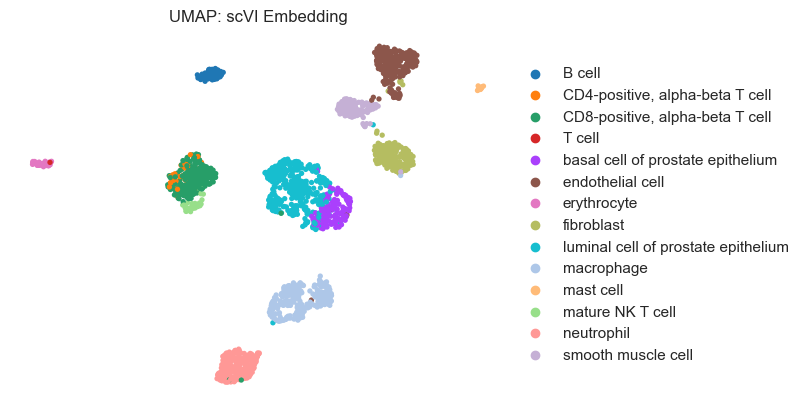

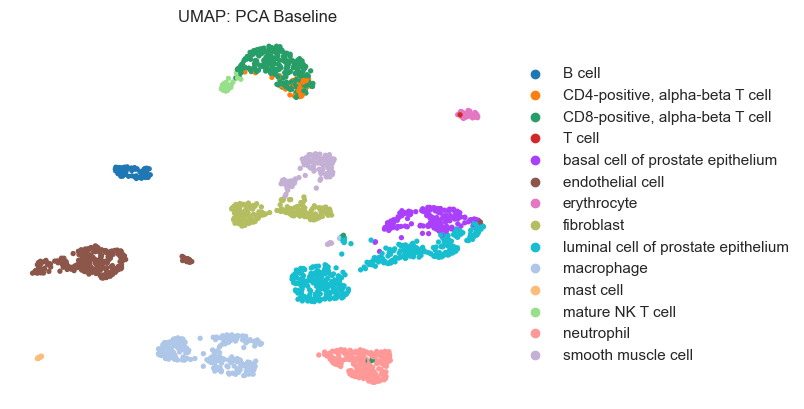

In [13]:
# Generate UMAP visualizations
plot_umap(model_output, dataset.labels, "UMAP: scVI Embedding")
plot_umap(clustering_baseline, dataset.labels, "UMAP: PCA Baseline")

#### Visualize Clustering Results

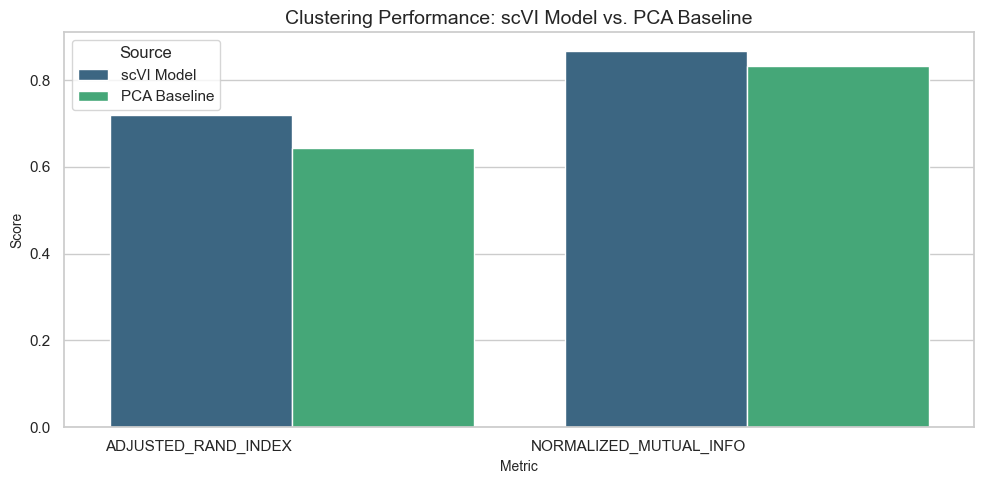

In [14]:
plot_comparison(
    df_clustering_compare,
    title="Clustering Performance: scVI Model vs. PCA Baseline",
    ylabel="Score",
    palette="viridis",
)

#### Visualize Embedding Results

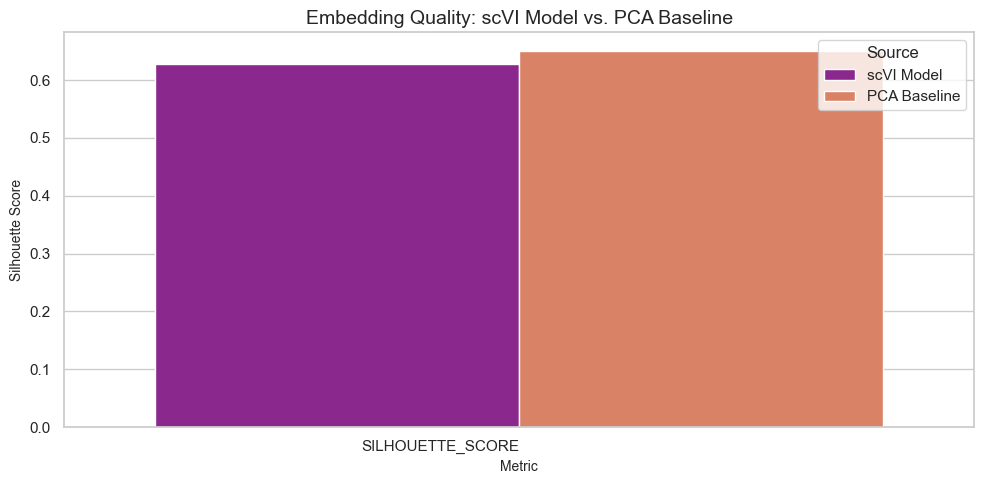

In [15]:
plot_comparison(
    df_embedding_compare,
    title="Embedding Quality: scVI Model vs. PCA Baseline",
    ylabel="Silhouette Score",
    palette="plasma",
)

#### Visualize Prediction Results

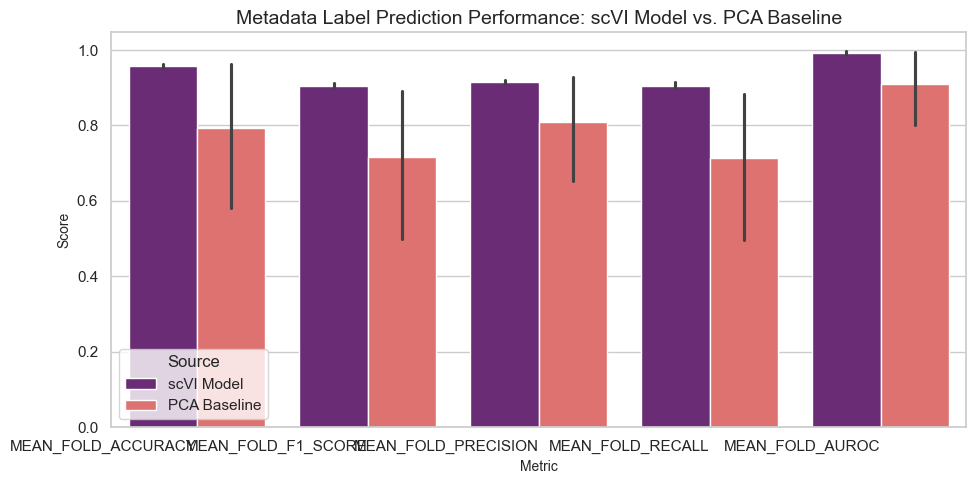

In [16]:
plot_comparison(
    df_prediction_compare,
    title="Metadata Label Prediction Performance: scVI Model vs. PCA Baseline",
    ylabel="Score",
    palette="magma",
)

### Results Interpretation

The benchmarking results provide insights into the performance of the scVI model compared to a PCA baseline across three tasks:

1. **Clustering**: Metrics such as Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) indicate how well the model groups cells into clusters.
2. **Embedding**: Silhouette scores measure the quality of embeddings, reflecting how well-separated cell types are in the latent space.
3. **Cell Type Classification**: Accuracy and F1 scores evaluate the model's ability to predict cell types based on metadata.

Higher scores for the scVI model compared to the PCA baseline suggest that the model captures biological variation more effectively.